In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tqdm import tqdm
from datetime import datetime

# set the seed for reproducibility
np.random.seed(42)

In [53]:
train = pd.read_csv('./data/train_data.csv')

test = pd.read_csv('./data/test_data.csv')

In [58]:
# drop the out_pressure column
train.drop(['out_pressure'], axis=1, inplace=True)
test.drop(['out_pressure'], axis=1, inplace=True)

In [59]:
# Different facilities have different HP ratings for their compressors.
# We need to scale all the features based on the HP rating of the compressor.
# And make a general model that can be used for all facilities.

def transform(df):
    # divide each facility hp rating by 30hp to get the ratio
    hp_ratios = {0: 1.0, 1: 1.5, 2: 3.0, 3: 0.6, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}

    df = df.copy()
    # multiply the values with each column based on the type column
    df['air_inflow'] = df.apply(lambda x: x['air_inflow'] * hp_ratios[x['type']], axis=1)
    df['air_end_temp'] = df.apply(lambda x: x['air_end_temp'] * hp_ratios[x['type']], axis=1)
    df['motor_current'] = df.apply(lambda x: x['motor_current'] * hp_ratios[x['type']], axis=1)
    df['motor_rpm'] = df.apply(lambda x: x['motor_rpm'] * hp_ratios[x['type']], axis=1)
    df['motor_temp'] = df.apply(lambda x: x['motor_temp'] * hp_ratios[x['type']], axis=1)
    df['motor_vibe'] = df.apply(lambda x: x['motor_vibe'] * hp_ratios[x['type']], axis=1)

    # drop the type column
    df.drop(['type'], axis=1, inplace=True)

    return df

train = transform(train)
test = transform(test)

In [194]:
# scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler = RobustScaler()

train_scaled = scaler.fit_transform(train)

In [195]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# seed the random number generator
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [196]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [197]:
# Define the Autoencoder model architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 6)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [198]:
# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, X):
        self.X = X
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        # x = torch.from_numpy(x.to_numpy()).float()
        x = torch.from_numpy(x).float()
        return x, x

In [200]:
train_dataset = MyDataset(train_scaled)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [202]:
lr = 1e-3
num_epochs = 50

history = []

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model.cuda()

for epoch in range(num_epochs):
    loss = 0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    history.append(loss.item())

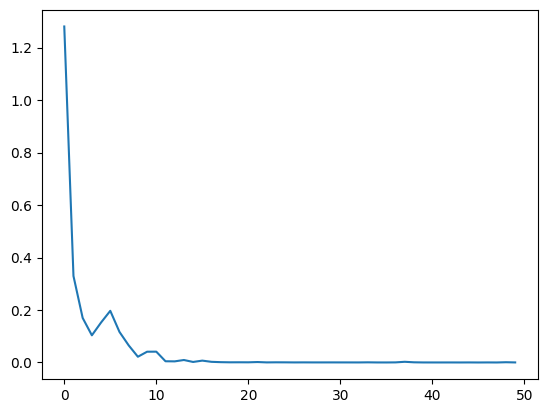

In [204]:
# plot the loss curve
plt.plot(history)
plt.show()

In [206]:
train_data = torch.from_numpy(train_scaled).float()

with torch.no_grad():
    train_data = train_data.to(device)
    reconstructions = model(train_data)

train_recon_loss = np.mean(np.square(reconstructions.cpu().numpy() - train_data.cpu().numpy()), axis=1)

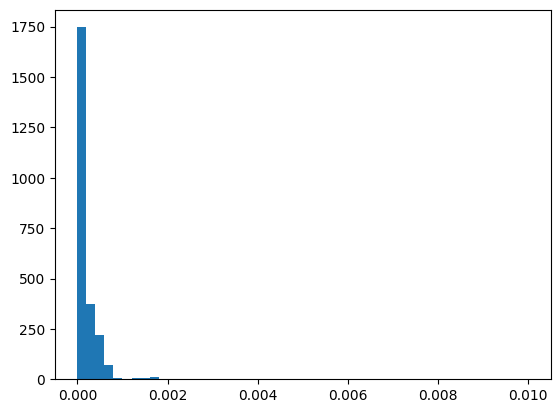

In [225]:
# plot histogram
plt.hist(train_recon_loss, bins=50, range=(0, 0.01))
plt.show()

In [210]:
# scale the test data
test_scaled = scaler.transform(test)

# convert the test data to torch tensor
test_data = torch.from_numpy(test_scaled).float()

In [212]:
with torch.no_grad():
    test_data = test_data.to(device)
    reconstructions = model(test_data)

test_recon_loss = np.mean(np.square(reconstructions.cpu().numpy() - test_data.cpu().numpy()), axis=1)

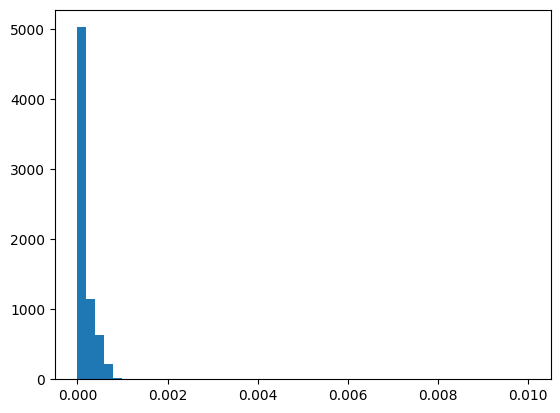

In [222]:
# plot histogram
plt.hist(test_recon_loss, bins=50, range=(0, 0.01))
plt.show()

In [226]:
# define the threshold
threshold = np.percentile(train_recon_loss, 99)

print("Threshold: {}".format(threshold))

Threshold: 0.0016348704253323402


In [228]:
# classify the test data as normal 0 or abnormal 1 based on the threshold
pred = np.where(test_recon_loss > threshold, 1, 0)

In [229]:
# load answer_sample.csv
answer = pd.read_csv('./data/answer_sample.csv')

In [231]:
# save the results in the csv file
answer['label'] = pred
answer.to_csv('submission_{}.csv'.format(datetime.now().strftime("%y.%m.%d_%H.%M.%S")), index=False)